In [180]:
from __future__ import division
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from src.sentimentAnalysis import detect_sentiment, setRating
import cPickle as pickle
from pymongo import MongoClient
from collections import defaultdict
import enchant
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
connection = MongoClient()
db = connection.wta
tripReports = db.trip_reports

In [49]:
def mongo2PandasClean(mongodb, clean_creator=True, drop_id=True):
    df = pd.DataFrame(list(mongodb.find()))
    if clean_creator:
        df['Creator']= [cr.strip() for cr in df['Creator']]
    if drop_id:
        del df['_id']
    return df

In [4]:
df = mongo2PandasClean(tripReports)

In [5]:
df.head()

,Creator,Date,Name,Text
0,amart005,"Jul 31, 2016",Grand Park via Lake Eleanor,"The first meadow is a marshy mess, but after t..."
1,xandwich,"Jul 26, 2016",Grand Park via Lake Eleanor,Well...we got to Mount Rainier Tuesday morning...
2,HeatherD,"Jul 25, 2016",Grand Park via Lake Eleanor,Found hiking poles at Lake Eleanor. Comment wi...
3,Lindy99,"Jul 24, 2016",Grand Park via Lake Eleanor,"The WTA guide says this hike is 1,100 foot ele..."
4,SpartanHiker,"Jul 23, 2016",Grand Park via Lake Eleanor,Wonderful hike to Grand park. Overall the tra...


### Adding Author ID

In [6]:
authors = np.unique(df.Creator)
ider = dict(zip(authors, range(len(authors))))
df['author_id'] = [ider[r] for r in df['Creator']]

### Unpickle Hike identifier and id hikes

In [7]:
with open('pickle/ider.pkl', 'rb') as f:
    ider = pickle.load(f)
df['hike_id'] = [ider[t.encode('utf-8')] for t in df['Name']]

In [8]:
df.head()

,Creator,Date,Name,Text,author_id,hike_id
0,amart005,"Jul 31, 2016",Grand Park via Lake Eleanor,"The first meadow is a marshy mess, but after t...",12474,0
1,xandwich,"Jul 26, 2016",Grand Park via Lake Eleanor,Well...we got to Mount Rainier Tuesday morning...,19583,0
2,HeatherD,"Jul 25, 2016",Grand Park via Lake Eleanor,Found hiking poles at Lake Eleanor. Comment wi...,4317,0
3,Lindy99,"Jul 24, 2016",Grand Park via Lake Eleanor,"The WTA guide says this hike is 1,100 foot ele...",6676,0
4,SpartanHiker,"Jul 23, 2016",Grand Park via Lake Eleanor,Wonderful hike to Grand park. Overall the tra...,10392,0


## Sentiment analysis

In [9]:
df['TextBlobSentiment'] = [detect_sentiment(t) for t in df['Text']]

In [10]:
df['Rating']= setRating(df, 'TextBlobSentiment')

In [11]:
df.head()

,Creator,Date,Name,Text,author_id,hike_id,TextBlobSentiment,Rating
0,amart005,"Jul 31, 2016",Grand Park via Lake Eleanor,"The first meadow is a marshy mess, but after t...",12474,0,0.125246,2
1,xandwich,"Jul 26, 2016",Grand Park via Lake Eleanor,Well...we got to Mount Rainier Tuesday morning...,19583,0,0.151480,3
2,HeatherD,"Jul 25, 2016",Grand Park via Lake Eleanor,Found hiking poles at Lake Eleanor. Comment wi...,4317,0,0.000000,1
3,Lindy99,"Jul 24, 2016",Grand Park via Lake Eleanor,"The WTA guide says this hike is 1,100 foot ele...",6676,0,0.225347,4
4,SpartanHiker,"Jul 23, 2016",Grand Park via Lake Eleanor,Wonderful hike to Grand park. Overall the tra...,10392,0,0.215000,4


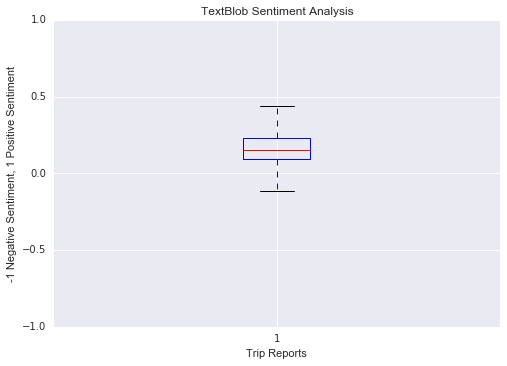

In [15]:
_=plt.boxplot(df.TextBlobSentiment)
plt.title('TextBlob Sentiment Analysis')
plt.ylabel('-1 Negative Sentiment, 1 Positive Sentiment')
plt.xlabel('Trip Reports')

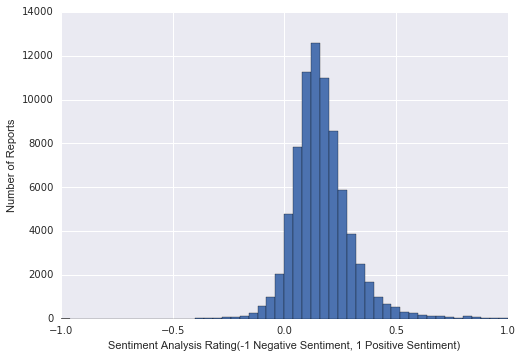

In [28]:
_=plt.hist(df['TextBlobSentiment'], bins=50)
plt.title('Distribution of TextBlob Sentiment Ratings on Trip Reports')
plt.ylabel('Number of Reports')
plt.xlabel('Sentiment Analysis Rating (-1 Negative Sentiment, 1 Positive Sentiment)')

## Using Dato Graphlab sentiment analysis:

https://turi.com/products/create/docs/generated/graphlab.sentiment_analysis.create.html#graphlab.sentiment_analysis.create


In [19]:
import graphlab as gl

In [20]:
#df = df.dropna()
df['hike_id'] = df['hike_id'].fillna(np.nan).astype(int)
df['author_id'] = df['author_id'].fillna(np.nan).astype(int)
sf = gl.SFrame(df)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1470079649.log
INFO:graphlab.cython.cy_server:GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1470079649.log


This non-commercial license of GraphLab Create for academic use is assigned to jat257@cornell.edu and will expire on June 30, 2017.


In [21]:
m = gl.sentiment_analysis.create(sf, features=['Text'])

In [22]:
df['GraphLabSentiment'] = m.predict(sf)

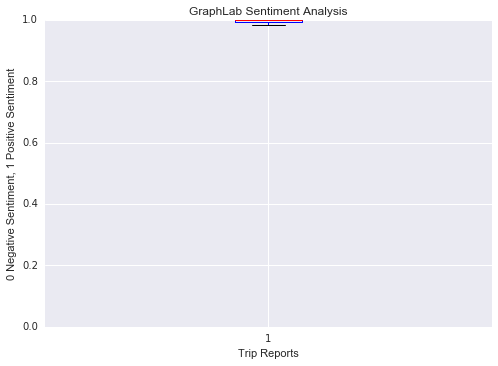

In [27]:
_=plt.boxplot(df['GraphLabSentiment'])
plt.title('GraphLab Sentiment Analysis')
plt.ylabel('0 Negative Sentiment, 1 Positive Sentiment')
plt.xlabel('Trip Reports')

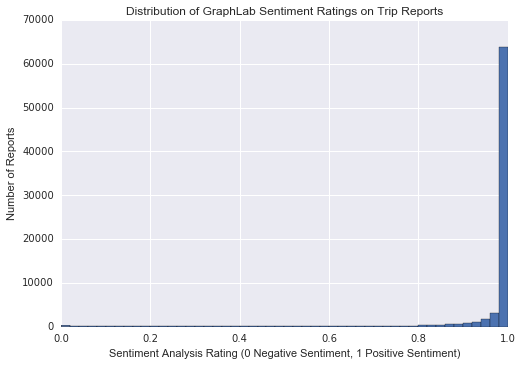

In [29]:
_=plt.hist(df['GraphLabSentiment'], bins=50)
plt.title('Distribution of GraphLab Sentiment Ratings on Trip Reports')
plt.ylabel('Number of Reports')
plt.xlabel('Sentiment Analysis Rating (0 Negative Sentiment, 1 Positive Sentiment)')

## Attempting GraphLab's sentiment analysis with scraped TR training data

Using data gathered from everytrail.com

In [50]:
connection.close()

In [51]:
connection = MongoClient()
db = connection.wta
train = db.trainingTR

train_df = mongo2PandasClean(train, clean_creator=False)

In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 3 columns):
Name      523 non-null object
Rating    523 non-null object
Text      523 non-null object
dtypes: object(3)
memory usage: 12.3+ KB


In [55]:
train_df['Rating'] = [int(r) for r in train_df['Rating']]

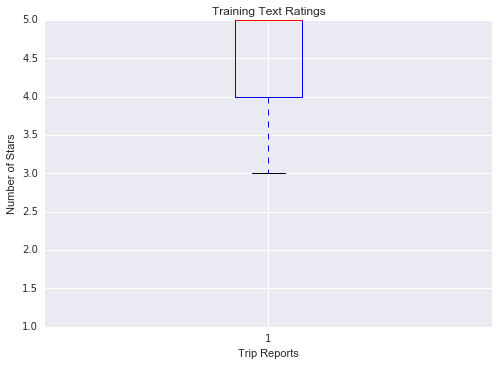

In [57]:
_=plt.boxplot(train_df.Rating)
plt.title('Training Text Ratings')
plt.ylabel('Number of Stars')
plt.xlabel('Trip Reports')

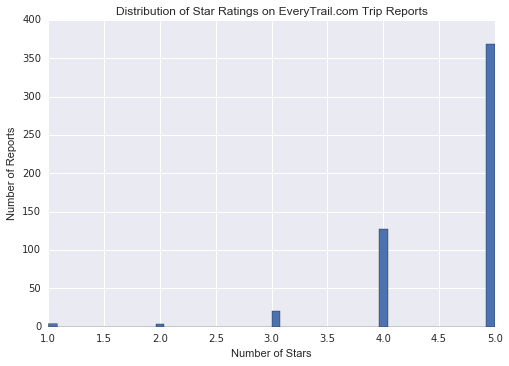

In [60]:
_=plt.hist(train_df.Rating, bins=50)
plt.title('Distribution of Star Ratings on EveryTrail.com Trip Reports')
plt.ylabel('Number of Reports')
plt.xlabel('Number of Stars')

In [61]:
train_df.Rating.value_counts()

5    369
4    127
3     20
1      4
2      3
Name: Rating, dtype: int64

In [63]:
train_sf = gl.SFrame(train_df)

In [69]:
trained_model = gl.sentiment_analysis.create(train_sf, target='Rating', features=['Text'], method='bow-logistic')

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

Logistic regression:

--------------------------------------------------------

Number of examples          : 476

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 5422

Number of coefficients    : 5423

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.002101  | 0.026048     | 0.993697          | 0.925926            |

| 2         | 5        | 1.000000  | 0.047382     | 0.997899          | 0.925926            |

| 3         | 6        | 1.000000  | 0.057873     | 0.997899          | 0.925926            |

| 4         | 7        | 1.000000  | 0.067319     | 1.000000          | 0.925926            |

| 5         | 8        | 1.000000  | 0.076963     | 1.000000          | 0.925926            |

| 6         | 9        | 1.000000  | 0.098179     | 1.000000          | 0.925926            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



In [70]:
df['TrainedModelSentiment'] = trained_model.predict(sf)

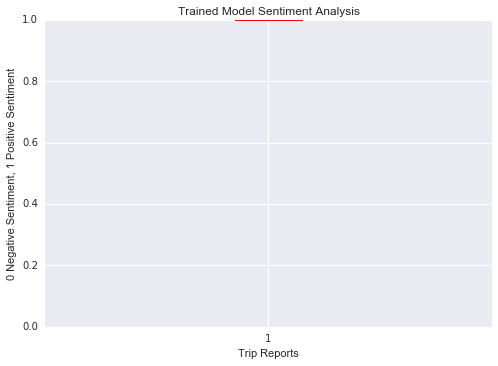

In [71]:
_=plt.boxplot(df['TrainedModelSentiment'])
plt.title('Trained Model Sentiment Analysis')
plt.ylabel('0 Negative Sentiment, 1 Positive Sentiment')
plt.xlabel('Trip Reports')

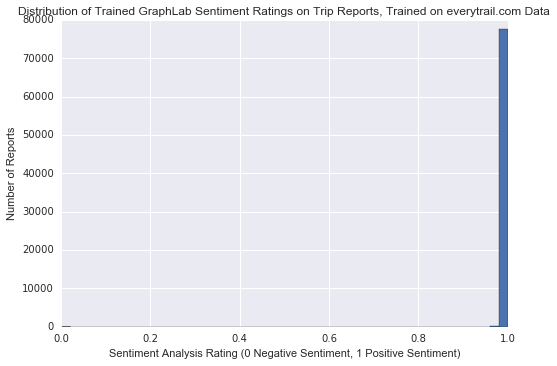

In [72]:
_=plt.hist(df['TrainedModelSentiment'], bins=50)
plt.title('Distribution of Trained GraphLab Sentiment Ratings on Trip Reports, Trained on everytrail.com Data')
plt.ylabel('Number of Reports')
plt.xlabel('Sentiment Analysis Rating (0 Negative Sentiment, 1 Positive Sentiment)')

### With Oversampling?

## Attempting word graphs as seen in 
http://varianceexplained.org/r/yelp-sentiment/

In [90]:
def addWordScores(text, rating, def_dict):
    for word in text.lower().strip().split():
        def_dict[word.strip(string.punctuation)].append(rating)
    return def_dict           

In [161]:
def WordScoretoPandasDF(df, text_col='Text', rating_col='Rating', drop_numbers=True):
    wordRatingTBS = defaultdict(list)
    for i in df.index.tolist():
        wordRatingTBS = addWordScores(df[text_col][i], df[rating_col][i], wordRatingTBS)
    avegWordRatingTBS = dict()
    cntWordRatingTBS = dict()
    for k, v in wordRatingTBS.iteritems():
        avegWordRatingTBS[k] = np.mean(v)
        cntWordRatingTBS[k] = len(v)
    words = pd.DataFrame(avegWordRatingTBS.items(), columns=['Words', 'Average Rating'])
    words['Number of Occurences'] = [cntWordRatingTBS[w] for w in words['Words']]
    words = words.ix[1:]
    return words

In [172]:
def dropNonWords(df, column):
    i_tokeep = []
    d = enchant.Dict("en_US")
    for i, w in enumerate(df[column]):
        if d.check(w):
            i_tokeep.append(i)
    return df.ix[i_tokeep]
            

In [191]:
TBS = WordScoretoPandasDF(df)

In [192]:
TBS.head()

,Words,Average Rating,Number of Occurences
1,fawn,2.792593,135
2,ago.first,3.000000,1
3,fine....overall,1.000000,4
4,35mi,2.000000,2
5,wooda,5.000000,1


In [193]:
TBS = dropNonWords(TBS, 'Words')

In [194]:
TBS[TBS['Words'] not in stopwords.words('english')]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [189]:
TBS.head(20)

,Words,Average Rating,Number of Occurences
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,wooda,5.000000,1.0
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


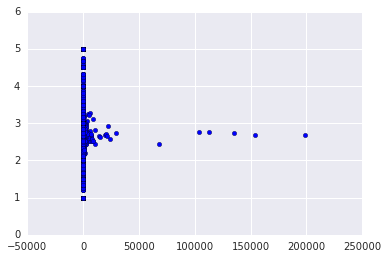

In [186]:
plt.scatter(TBS['Number of Occurences'], TBS['Average Rating'])

In [190]:
TBS[TBS['Number of Occurences']>5000]

,Words,Average Rating,Number of Occurences
952,has,2.675014,19647.0
2302,with,2.759277,113159.0
4844,worth,3.108450,8935.0
7666,meadow,2.681046,6653.0
8820,times,2.615717,6719.0
9702,met,2.648915,5070.0
10632,down,2.447916,67794.0
12197,hour,2.644291,7225.0
13647,reached,2.534766,8514.0
14147,like,2.715707,20201.0


In [188]:
word = 'has'
word in stopwords.words('english')

True

In [ ]:
wordRatingTMS = defaultdict(list)
for i in df.index.to_list:
    wordRatingsTMS = addWordScores(train_df['Text'][i], train_df['Rating'][i], wordRatingsTMS)
   


## To CSV

In [197]:
df.to_csv('data/tripReports.csv',  encoding='utf-8')